## Introduction ##
I previously wrote a "naive betting analysis" kernel (see [here][1]), wherein I explored if we'd make a profit by just betting on the favourite or the longshot outcome in each match. Turns out those strategies would only yield losses in the long run, so other smarter strategies were required to beat the bookies. In this notebook I'm exploring accumulator bets.

An accumulator is when you place a single bet on the outcome of multiple matches together. Say there are 4 matches M1, M2, M3 & M4, with odds (for the favourite in each of these matches) being O1, O2, O3 & O4. Say I feel confident that the favourites are going to win these 4 matches. So instead of betting 1 dollar separately on each match, I'll place a single bet of 1 dollar on all 4 of these teams to win. (referred to as a 4-fold accumulator). The new odds O_accum=O1 X O2 X O3 X O4, & I'll receive a payout *only if* all 4 of my teams win. There is a risk involved as it takes only 1 wrong outcome to screw up your bet, but it can be used to substantially increase your payouts when you're fairly confident.

Whats more, Bet365 also offers a bonus when you win your accumulator bet, based on the number of folds involved (check details [here][2]). So in my example above, if I bet 1 dollar and my 4-fold accumulator bet came true, I'd receive an additional 10% bonus, so my payout would be:

P=O1 X O2 X O3 X O4 X 1.10

Now that we understand how the accumulator bet works, we can get started. I'm using data only of the past 5 seasons for my analysis (i.e from 2011/12 season onwards). Based on my own knowledge of the football leagues, I picked 12 teams that were dominant over that period. I'll analyse the payouts I'd receive if I placed accumulator bets on matches of these teams. The teams I've chosen are:

 - Barcelona (3X winner, 2X runner-up in Spanish league)
 - Real Madrid (1X winner, 3X runner-up in Spanish league)
 - Atletico Madrid (1X winner in Spanish league)
 - Paris Saint Germain (5X winner in French league)
 - Juventus (5X winner in Italian league)
 - Bayern Munich (4X winner, 1X runner-up in German league)
 - Borussia Dortmund (1X winner, 3X runner-up in German league)
 - Celtic (5X winner in Scottish league)
 - Benfica (3X winner, 2X runner-up in Portuguese league)
 - Porto (2X winner, 1X runner-up in Portuguese league)
 - Manchester City (2X winner, 2X runner-up in EPL)
 - Arsenal (consistently finish in top 4 of the EPL every year)

I'll first compute the net-payout for each team individually over the 5 seasons. I'll sort them in descending order of payout, & build a 2-fold accumulator of the best 2 teams. I'll progressively keep increasing the folds & compute the net-payout, to find the "optimum accumulator" that maximizes payout.


  [1]: https://www.kaggle.com/sadz2201/d/hugomathien/soccer/naive-betting-analysis/notebook
  [2]: http://extra.bet365.com/promotions/soccer/soccer-accumulator-bonus

**Import Libraries, load the data**

In [1]:
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)
import sqlite3
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('../input/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

/tmp/ipykernel_18/536951066.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [2]:
with sqlite3.connect('../input/database.sqlite') as con:
    m = pd.read_sql_query("""select player_name, overall_rating 
                      from `Player` p 
                      left join `Player_Attributes` pa 
                      on  p.id = pa.player_api_id 
                      WHERE player_name like '%Messi%';""", con)
    print(m)

    player_name overall_rating
0  Lionel Messi           None


Merge data, select most recent 5 seasons, retain only relevant columns

In [3]:
selected_countries = ['Scotland','France','Germany','Italy','Spain','Portugal','England']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

#There's a special character in the long name "Atlético Madrid".
#This can be a pain in the ass, so I'm gonna change it for simplicity.
teams.loc[teams.team_api_id==9906,"team_long_name"] = "Atletico Madrid"

#retain only data from 2011-12 season
matches=matches[matches.date>='2011-08-01']
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','home_team_goal','away_team_goal','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A
2868,2869,1729,1729,2011/2012,1,2011-08-13 00:00:00,1024172,8655,8602,1,2,2.20,3.20,3.5
2869,2870,1729,1729,2011/2012,1,2011-08-13 00:00:00,1024173,9879,10252,0,0,2.20,3.20,3.5
2870,2871,1729,1729,2011/2012,1,2011-08-13 00:00:00,1024175,8650,8472,1,1,1.57,3.60,7.0
2871,2872,1729,1729,2011/2012,1,2011-08-15 00:00:00,1024179,8456,10003,4,0,1.29,5.00,13.0
2872,2873,1729,1729,2011/2012,1,2011-08-13 00:00:00,1024182,10261,9825,0,0,3.75,3.25,2.1


Team API id's don't tell us anything. Lets merge team names

In [4]:
matches=matches.merge(teams,left_on='home_team_api_id',right_on='team_api_id',suffixes=('','_h'))
matches=matches.merge(teams,left_on='away_team_api_id',right_on='team_api_id',suffixes=('','_a'))
matches=matches[['id', 'season', 'date','home_team_goal','away_team_goal','B365H', 'B365D' ,'B365A',
                 'team_long_name','team_long_name_a']]
matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a
0,2869,2011/2012,2011-08-13 00:00:00,1,2,2.20,3.20,3.5,Blackburn Rovers,Wolverhampton Wanderers
1,2870,2011/2012,2011-08-13 00:00:00,0,0,2.20,3.20,3.5,Fulham,Aston Villa
2,2871,2011/2012,2011-08-13 00:00:00,1,1,1.57,3.60,7.0,Liverpool,Sunderland
3,2872,2011/2012,2011-08-15 00:00:00,4,0,1.29,5.00,13.0,Manchester City,Swansea City
4,2873,2011/2012,2011-08-13 00:00:00,0,0,3.75,3.25,2.1,Newcastle United,Arsenal


Retain data of only our chosen 12 teams for further analysis. Also since we have multiple teams from the same league (Barca, Real & Atletico from Spain; Bayern & Dortmund from Germany; Benfica & Porto from Portugal; Mancity & Arsenal from EPL), I'll remove the matches where they face off against each other. It's hard to pick a winner in these, so it's best to leave them out of our accumulators

In [5]:
accumulator_teams=['FC Barcelona','Real Madrid CF','Celtic','FC Porto','SL Benfica','Juventus','FC Bayern Munich','Paris Saint-Germain','Manchester City','Atletico Madrid','Borussia Dortmund','Arsenal']

#matches where any of our 12 teams is playing at home
matches_h=matches[matches.team_long_name.isin(accumulator_teams)]
#matches where any of our 12 teams is playing away
matches_a=matches[matches.team_long_name_a.isin(accumulator_teams)]
#concat & drop duplicates
matches=pd.concat([matches_h,matches_a],axis=0)
matches.drop_duplicates(inplace=True)

matches=matches.sort_values(by='date')
#remove matches where our teams are facing off against each other
matches=matches[~((matches.team_long_name.isin(accumulator_teams)) & (matches.team_long_name_a.isin(accumulator_teams)))]

matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a
3799,8727,2011/2012,2011-08-05 00:00:00,3,1,1.57,3.8,6.00,Borussia Dortmund,Hamburger SV
1909,5918,2011/2012,2011-08-06 00:00:00,0,1,1.53,3.8,6.75,Paris Saint-Germain,FC Lorient
3807,8735,2011/2012,2011-08-07 00:00:00,0,1,1.20,6.5,13.00,FC Bayern Munich,Borussia Mönchengladbach
8652,20510,2011/2012,2011-08-07 00:00:00,0,1,9.00,5.0,1.33,Aberdeen,Celtic
7209,18368,2011/2012,2011-08-12 00:00:00,2,2,9.00,4.2,1.40,Gil Vicente FC,SL Benfica


For our accumulators, we'll have to group the matches based on date. It is highly unlikely that all our teams play a match on the same date, but it is likely that they play within the same gameweek. Thus we need to do some post-processing on dates.

There can be weekend matches (Sat/Sun), or midweek matches (Tue/Wed). In extreme cases, a weekend match can be preponed to Friday or postponed to Monday, or a midweek match postponed to Thursday. 
I'll change the date of all weekend matches to the corresponding Saturday, & all midweek matches to the corresponding Tuesday.

In [6]:
matches.date=pd.to_datetime(matches.date)
#monday matches. subtract 2 to make it saturday
m0=matches[matches.date.dt.weekday==0]
m0.date=m0.date-timedelta(days=2)

#tuesday matches
m1=matches[matches.date.dt.weekday==1]
#wednesday matches. subtract 1 to make it tuesday
m2=matches[matches.date.dt.weekday==2]
m2.date=m2.date-timedelta(days=1)
#thursday matches. subtract 2 to make it tuesday
m3=matches[matches.date.dt.weekday==3]
m3.date=m3.date-timedelta(days=2)

#friday matches. add 1 to make it saturday
m4=matches[matches.date.dt.weekday==4]
m4.date=m4.date+timedelta(days=1)
#saturday matches
m5=matches[matches.date.dt.weekday==5]
#sunday matches. subtract 1 to make it saturday
m6=matches[matches.date.dt.weekday==6]
m6.date=m6.date-timedelta(days=1)

#merge all, sort by date
matches=pd.concat([m0,m1,m2,m3,m4,m5,m6],axis=0)
matches=matches.sort_values(by='date')
del m0,m1,m2,m3,m4,m5,m6

#checking if we have only saturday & tuesday now
matches.date.dt.weekday.value_counts()

date
5    1849
1     201
Name: count, dtype: int64

Find out which of our 12 chosen teams is playing in each match. Also find the venue & odds for the team. 

In [7]:
matches['our_team']='abc'
matches['our_venue']='H'
matches['our_odds']=matches.B365H

is_home=matches.team_long_name.isin(accumulator_teams)
#our team is playing at home
matches.our_team[is_home==True]=matches.team_long_name[is_home==True]

#our team is playing away.
matches.our_team[is_home==False]=matches.team_long_name_a[is_home==False]
matches.our_venue[is_home==False]='A'
matches.our_odds[is_home==False]=matches.B365A[is_home==False]

Compute the result of each match based on the goals. Also compute our payout for each match assuming we bet 1$ on our chosen team. 

In [8]:
matches['result']='H'
matches.loc[matches.home_team_goal==matches.away_team_goal,"result"]='D'
matches.loc[matches.home_team_goal<matches.away_team_goal,"result"]='A'

matches['payout']=matches.our_odds
#our team either lost or drew. reset payout to 0
matches.loc[~(matches.result==matches.our_venue),"payout"]=0
matches.head()

,id,season,date,home_team_goal,away_team_goal,B365H,B365D,B365A,team_long_name,team_long_name_a,our_team,our_venue,our_odds,result,payout
8652,20510,2011/2012,2011-08-06,0,1,9.00,5.0,1.33,Aberdeen,Celtic,Celtic,A,1.33,A,1.33
3807,8735,2011/2012,2011-08-06,0,1,1.20,6.5,13.00,FC Bayern Munich,Borussia Mönchengladbach,FC Bayern Munich,H,1.20,A,0.00
3799,8727,2011/2012,2011-08-06,3,1,1.57,3.8,6.00,Borussia Dortmund,Hamburger SV,Borussia Dortmund,H,1.57,H,1.57
1909,5918,2011/2012,2011-08-06,0,1,1.53,3.8,6.75,Paris Saint-Germain,FC Lorient,Paris Saint-Germain,H,1.53,A,0.00
3,2872,2011/2012,2011-08-13,4,0,1.29,5.0,13.00,Manchester City,Swansea City,Manchester City,H,1.29,H,1.29


Sanity check: Lets see if we're profitable so far. (Note, this is just individual bets, we haven't gone into accumulators yet).  

In [9]:
print(sum(matches.payout)/matches.shape[0])

1.0066682926829273


Turns out we're just about even. Let's analyze the matches won & net payout by each team.

In [10]:
team_n=matches.our_team.value_counts()
print ("win percentage by team:")
print(matches[matches.payout!=0].our_team.value_counts()/team_n)
print("_"*50)
print ("net payout by team:")
indiv_payout=matches.groupby('our_team')['payout'].sum()
indiv_payout=indiv_payout/team_n
print(indiv_payout)

win percentage by team:
our_team
Arsenal                0.583333
Atletico Madrid        0.664706
Borussia Dortmund      0.625000
Celtic                 0.735450
FC Barcelona           0.782353
FC Bayern Munich       0.812500
FC Porto               0.736486
Juventus               0.732620
Manchester City        0.655556
Paris Saint-Germain    0.678947
Real Madrid CF         0.794118
SL Benfica             0.821918
Name: count, dtype: float64
__________________________________________________
net payout by team:
our_team
Arsenal                0.981667
Atletico Madrid        1.063941
Borussia Dortmund      0.908125
Celtic                 0.977090
FC Barcelona           0.924412
FC Bayern Munich       1.025750
FC Porto               0.947905
Juventus               1.140321
Manchester City        1.004278
Paris Saint-Germain    1.010053
Real Madrid CF         0.982647
SL Benfica             1.106849
dtype: float64


Juventus & Benfica seem to be our star performers, with 14 & 10.68% profit themselves. I'm quite surprised that Atletico, PSG & Manchester City are profitable or even despite a low wins percentage, while Barcelona have losses. Also, the net payout for Real Madrid & Arsenal is nearly identical, despite Real winning 79.4% of their matches and Arsenal only winning 58.33%. Although a few teams have losses, I do believe they can help improve the overall profits of our accumulators because of their good wins percentage. 

**Accumulator**

In [11]:
#our teams list in sorted order of individual profits
accumulator_teams=['Juventus','SL Benfica','Atletico Madrid','FC Bayern Munich','Paris Saint-Germain','Manchester City','Real Madrid CF','Arsenal','Celtic','FC Porto','FC Barcelona','Borussia Dortmund']
#list of bet365 bonus payouts
#bonus[k]= bet365 bonus for k-fold accumulator
bonus=[1,1,1,1.05,1.1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]

folds = range(2,len(accumulator_teams)+1)
#blank dict
accum_payouts={}
for k in folds:
    #choose first k teams from the team list
    accum_subset=accumulator_teams[:k]
    
    #choose only matches involving these teams
    matches_kfold=matches[matches.our_team.isin(accum_subset)]
    #count of matches per date.
    date_counts=matches_kfold.date.value_counts().reset_index()
    date_counts.columns=['date','counts']
    
    #select only the dates where all k teams are in action
    dates_kfold=date_counts[date_counts.counts==k].date
    #retain only the matches happening on these dates
    matches_kfold=matches_kfold[matches_kfold.date.isin(dates_kfold)]
    #k-fold accumulator payout (product of payouts of all k teams on that date)
    payout_kfold=matches_kfold.groupby('date')['payout'].prod()
    #multiply bonus
    bonus_payout_kfold=payout_kfold* bonus[k]
    print(str(k) + " fold:")
    print(accum_subset)
    print("#bets: " + str(len(payout_kfold)))
    print("#correct predictions: " + str(len(payout_kfold[payout_kfold!=0])))
    print("Net outcome (without bonus): " + str(sum(payout_kfold)/len(payout_kfold)))
    print("Net outcome (after bonus): " + str(sum(bonus_payout_kfold)/len(payout_kfold)))
    print("_"*50)
    accum_payouts[k]=sum(bonus_payout_kfold)/len(payout_kfold)
    
#print the best choice of k, the corresponding teams & net payout.
best_k=max(accum_payouts,key=accum_payouts.get)
print("best k= " +str(best_k) )
print(accumulator_teams[:best_k])
print("best payout= " +str(accum_payouts[best_k]))

2 fold:
['Juventus', 'SL Benfica']
#bets: 129
#correct predictions: 85
Net outcome (without bonus): 1.4087813953488375
Net outcome (after bonus): 1.4087813953488375
__________________________________________________
3 fold:
['Juventus', 'SL Benfica', 'Atletico Madrid']
#bets: 112
#correct predictions: 54
Net outcome (without bonus): 1.5913375803571426
Net outcome (after bonus): 1.6709044593750007
__________________________________________________
4 fold:
['Juventus', 'SL Benfica', 'Atletico Madrid', 'FC Bayern Munich']
#bets: 95
#correct predictions: 37
Net outcome (without bonus): 1.6568002075789476
Net outcome (after bonus): 1.8224802283368426
__________________________________________________
5 fold:
['Juventus', 'SL Benfica', 'Atletico Madrid', 'FC Bayern Munich', 'Paris Saint-Germain']
#bets: 91
#correct predictions: 28
Net outcome (without bonus): 1.8342632294681316
Net outcome (after bonus): 2.017689552414945
__________________________________________________
6 fold:
['Juventus'

**Success!**

We've just found that accumulators are a winning strategy. The best results are obtained by placing an 8-fold accumulator in every week when Juventus, Benfica, Atletico, PSG, Bayern, ManCity, Real Madrid & Arsenal are all in action. A 7-fold accumulator ignoring Arsenal from the list is not too far off either. This strategy would've given us a net profit of 219.6% (i.e more than tripling our bank balance) over 5 years, which I think is a pretty good return on investment. Note that the success rate of our bets is quite low (20.3% for 7-fold, 11.3% for 8-fold). Even so, our winnings due to the high odds & bonuses far outweigh our losses.

I'm fairly convinced, & am going to try out this strategy at bet365.com for the remainder of the 2016-17 season. If you are heading over to create your account & start betting too, please upvote this notebook before you do so. :-)
[Also note - the 8 fold accumulator has already been successful 3 times so far this season. Twice for league fixtures, & once when I included cup fixtures of some of these teams. Also, Celtic have won 23 of their 24 league games so far this season, so it might make sense to make it into 9 fold accumulator to milk a little more profits :-) ]

There's still quite some room for experimentation. We could add in other teams to the mix. We can also try out better optimization & search strategies. (I've just restricted myself to greedy optimization by adding in the next-best team in each iteration)

**Ending notes**

 - 219% profit might be an optimistic estimate, because I've used hindsight knowledge of teams over the past 5 seasons, & I'm assuming that they'll continue to be dominant in the near future as well. Also as teams continue to dominate, the bookmakers will realize this & progressively keep decreasing the odds on their matches.
 - Despite it's success in the past, there is no guarantee it'll work in the future.
 - This a proposed strategy for success over time, & not to become a millionaire overnight.
 - Please choose your betting stakes wisely, & bear in mind that I take no responsibility for any losses incurred.

 

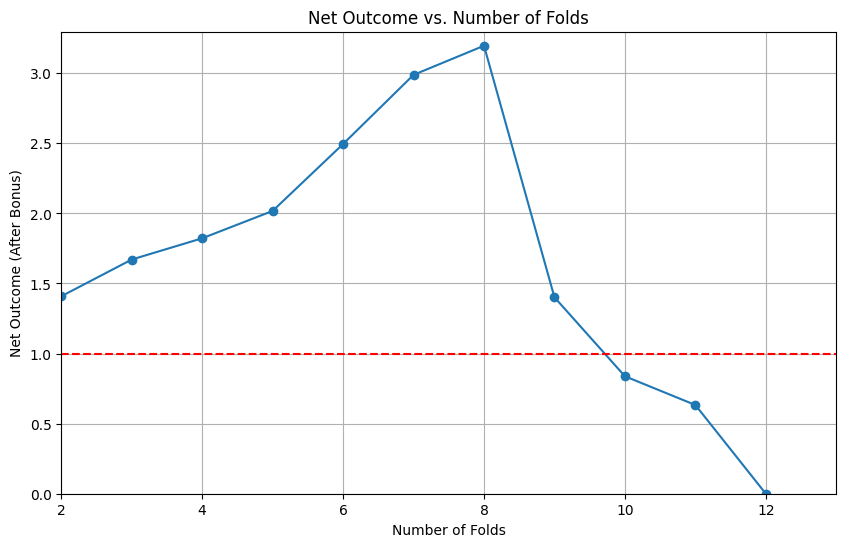

In [12]:
import matplotlib.pyplot as plt

net_outcomes = list(accum_payouts.values())

plt.figure(figsize=(10, 6)) 
plt.plot(folds, net_outcomes, marker='o', linestyle='-')  
plt.xlabel("Number of Folds")
plt.ylabel("Net Outcome (After Bonus)")
plt.title("Net Outcome vs. Number of Folds")
plt.grid(True) 

plt.xlim(min(folds), max(folds) + 1)  
plt.ylim(0, max(net_outcomes) + 0.1)  
plt.axhline(y=1.0, color='r', linestyle='--', label='Baseline') 

plt.show()


***Analysis***

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns  #Visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "../input/"  #Insert path here
database = path + 'database.sqlite'

In [14]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [15]:
countries = pd.read_sql("""SELECT *
                        FROM Player;""", conn)
countries

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...,...,...
11055,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172


In [16]:
leagues = pd.read_sql("""SELECT *
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", conn)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [17]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name
                        LIMIT 10;""", conn)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


In [18]:
detailed_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER by date
                                LIMIT 10;""", conn)
detailed_matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0
5,21522,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Racing Santander,Sevilla FC,1,1
6,21523,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Sporting de Gijón,Getafe CF,1,2
7,21524,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Betis Balompié,RC Recreativo,0,1
8,21526,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Athletic Club de Bilbao,UD Almería,1,3
9,21527,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Atlético Madrid,Málaga CF,4,0


In [19]:
leages_by_season = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY Country.name, League.name, season DESC
                                ;""", conn)
leages_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


<Axes: title={'center': 'Average Goals per Game Over Time'}>

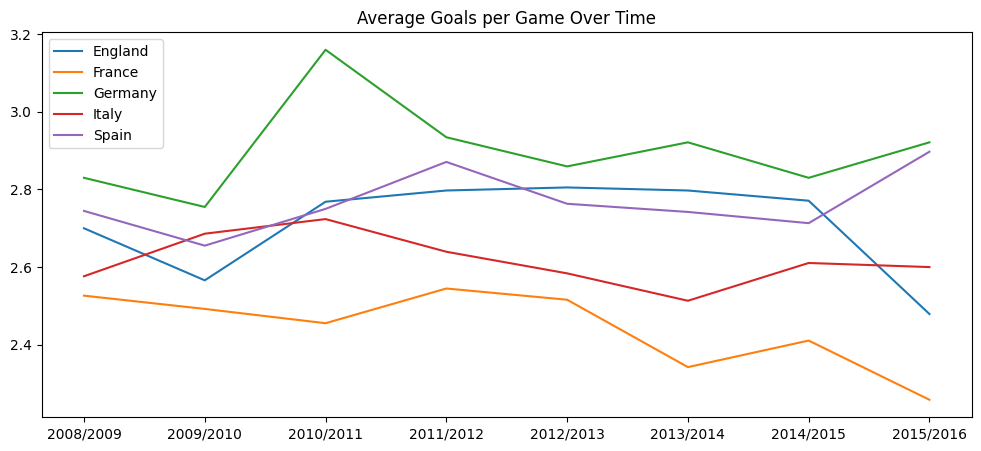

In [20]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time')

<Axes: title={'center': 'Average Goals Difference Home vs Out'}>

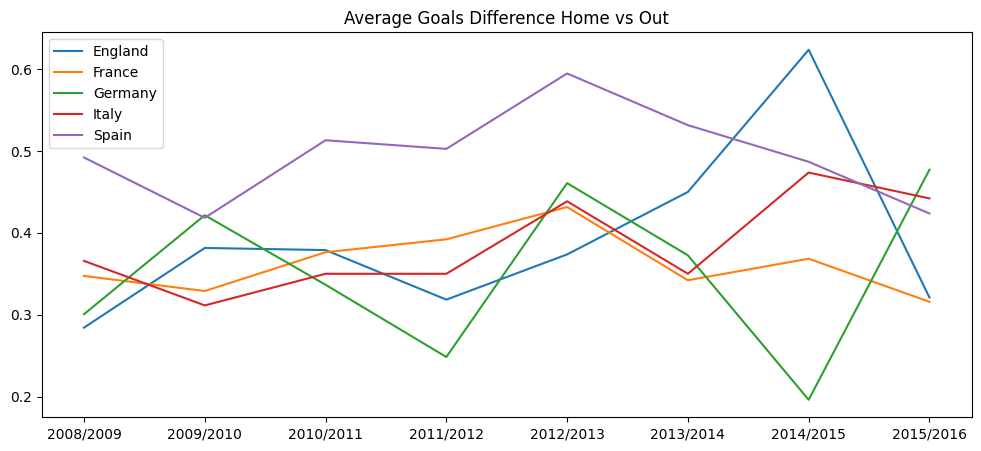

In [21]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])

df.plot(figsize=(12,5),title='Average Goals Difference Home vs Out')

In [22]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height, 
                                        COUNT(height) AS distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight 
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential  
                                        FROM Player_Attributes
                                        GROUP BY Player_Attributes.player_api_id) 
                                        AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", conn)
players_height

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


<Axes: title={'center': 'Potential vs Height'}, xlabel='calc_height'>

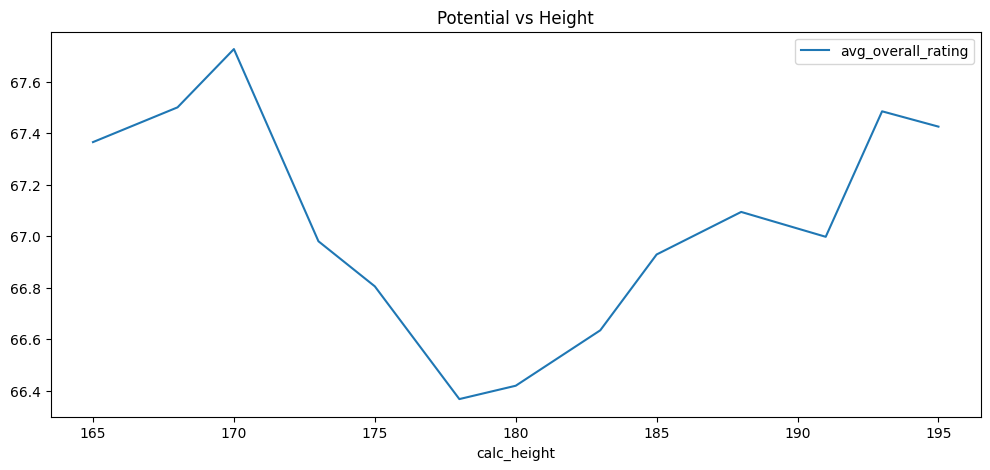

In [23]:
players_height.plot(x='calc_height',y='avg_overall_rating',figsize=(12,5),title='Potential vs Height')


****List of Matches****

In this exapmle we will show only the columns that interests us, so instead of * we will use the exact names.

Some of the cells have the same name (Country.name,League.name). We will rename them using AS.

As you can see, this query has much more joins. The reasons is because the DB is designed in a star structure - one table (Match) with all the "performance" and metrics, but only keys and IDs, while all the descriptive information stored in other tables (Country, League, Team)
And then I am creating different tables for all the leagues from the dataset matches which I'll later store in Matches.

In [24]:
matches_Spain = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain' 
                                ORDER by date
                               ;""", conn)
#matches.head() #It gives us first 5 matches in Spanish League in season 2008/09

matches_Eng = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'England' 
                                ORDER by date
                               ;""", conn)

matches_Ger = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Germany' 
                                ORDER by date
                               ;""", conn)

matches_Por = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Portugal' 
                                ORDER by date
                               ;""", conn)

matches_Italy = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Italy' 
                                ORDER by date
                               ;""", conn)

matches_France = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'France' 
                                ORDER by date
                               ;""", conn)

matches_Bel = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Belgium' 
                                ORDER by date
                               ;""", conn)

matches_Ned = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Netherlands' 
                                ORDER by date
                               ;""", conn)

matches_Pol = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Poland' 
                                ORDER by date
                               ;""", conn)

matches_Scot = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Scotland' 
                                ORDER by date
                               ;""", conn)

matches_Swt = pd.read_sql("""SELECT Match.id, 
                            Country.name AS country_name, 
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Switzerland' 
                                ORDER by date
                               ;""", conn)

**Making a list of all the leagues matches**

So here we created a list of matches in all respective leagues so that we can iterate over all the leagues to do other calculations easily.

In [25]:
matches = [matches_Spain,matches_Eng,matches_Italy,matches_Ger,matches_Por,matches_France,matches_Swt,matches_Pol,matches_Scot,matches_Ned,matches_Bel]


In [26]:
def goal_diff(fun):
    for i in fun:
        i['goal_diff'] = i['home_team_goal']-i['away_team_goal']
        print(i.tail())

goal_diff(matches)  

         id country_name      league_name     season  stage  \
3035  24490        Spain  Spain LIGA BBVA  2015/2016     38   
3036  24491        Spain  Spain LIGA BBVA  2015/2016     38   
3037  24492        Spain  Spain LIGA BBVA  2015/2016     38   
3038  24495        Spain  Spain LIGA BBVA  2015/2016     38   
3039  24497        Spain  Spain LIGA BBVA  2015/2016     38   

                     date               home_team      away_team  \
3035  2016-05-15 00:00:00  Real Sporting de Gijón  Villarreal CF   
3036  2016-05-15 00:00:00     Real Betis Balompié      Getafe CF   
3037  2016-05-15 00:00:00            RCD Espanyol       SD Eibar   
3038  2016-05-15 00:00:00               Málaga CF  UD Las Palmas   
3039  2016-05-15 00:00:00          Rayo Vallecano     Levante UD   

      home_team_goal  away_team_goal  goal_diff  
3035               2               0          2  
3036               2               1          1  
3037               4               2          2  
3038        

In [27]:
def des_stats(fun):
    for i in fun:
        print(i.country_name[0])
        print('')
        print('Mean')
        print('Home Goals =',i['home_team_goal'].mean())
        print('Away Goals =',i['away_team_goal'].mean())
        print('Goal Diff =',i['goal_diff'].mean())
        print('')
        print('Standard Deviation')
        print('Home Goals =',i['home_team_goal'].std())
        print('Away Goals =',i['away_team_goal'].std())
        print('Goal Diff =',i['goal_diff'].std())
        print('\n')

        
des_stats(matches)

Spain

Mean
Home Goals = 1.63125
Away Goals = 1.1358552631578946
Goal Diff = 0.4953947368421053

Standard Deviation
Home Goals = 1.388339449290436
Away Goals = 1.1610793358727831
Goal Diff = 1.885321587446922


England

Mean
Home Goals = 1.550986842105263
Away Goals = 1.1595394736842106
Goal Diff = 0.39144736842105265

Standard Deviation
Home Goals = 1.3116152875537903
Away Goals = 1.144628980736412
Goal Diff = 1.7891650087739002


Italy

Mean
Home Goals = 1.500828637719589
Away Goals = 1.1160092807424593
Goal Diff = 0.3848193569771296

Standard Deviation
Home Goals = 1.221796944942295
Away Goals = 1.0783923022135873
Goal Diff = 1.618877440273919


Germany

Mean
Home Goals = 1.6266339869281046
Away Goals = 1.2749183006535947
Goal Diff = 0.35171568627450983

Standard Deviation
Home Goals = 1.3395287742967286
Away Goals = 1.2003915693485308
Goal Diff = 1.8877547021083272


Portugal

Mean
Home Goals = 1.4083820662768032
Away Goals = 1.1262183235867447
Goal Diff = 0.2821637426900585

Stand

In [28]:
def result(fun):
    for i in fun:
        i['win'] = ((i['goal_diff']>0)*1)
        i['draw'] = ((i['goal_diff']==0)*1)
        i['lose'] = ((i['goal_diff']<0)*1)
        print(i.country_name[0])
        print('')
        print('win =' ,(i['win'].mean())*100,'%')
        print('draw =',(i['draw'].mean())*100,'%')
        print('lose =',(i['lose'].mean())*100,'%')
        print('\n')
    
result(matches)


Spain

win = 48.848684210526315 %
draw = 23.157894736842106 %
lose = 27.99342105263158 %


England

win = 45.723684210526315 %
draw = 25.756578947368418 %
lose = 28.519736842105264 %


Italy

win = 46.635730858468676 %
draw = 26.383824991713624 %
lose = 26.9804441498177 %


Germany

win = 45.220588235294116 %
draw = 24.387254901960784 %
lose = 30.392156862745097 %


Portugal

win = 44.2495126705653 %
draw = 25.97465886939571 %
lose = 29.775828460038987 %


France

win = 44.703947368421055 %
draw = 28.25657894736842 %
lose = 27.039473684210524 %


Switzerland

win = 45.71026722925457 %
draw = 24.331926863572434 %
lose = 29.957805907172997 %


Poland

win = 45.3125 %
draw = 27.34375 %
lose = 27.34375 %


Scotland

win = 41.66666666666667 %
draw = 24.50657894736842 %
lose = 33.82675438596491 %


Netherlands

win = 47.83496732026144 %
draw = 23.733660130718953 %
lose = 28.431372549019606 %


Belgium

win = 46.875 %
draw = 24.59490740740741 %
lose = 28.53009259259259 %




In [29]:
list_win = []
for i in matches:
    list_win.append(i['win'].mean())
#print(list_win) 


list_draw = []
for i in matches:
    list_draw.append(i['draw'].mean())
#print(list_draw)

list_lose = []
for i in matches:
    list_lose.append(i['lose'].mean())
    #print(list_lose)

list_countries = []

for i in matches:
    list_countries.append(i['country_name'][0])
    
#print(list_countries)    

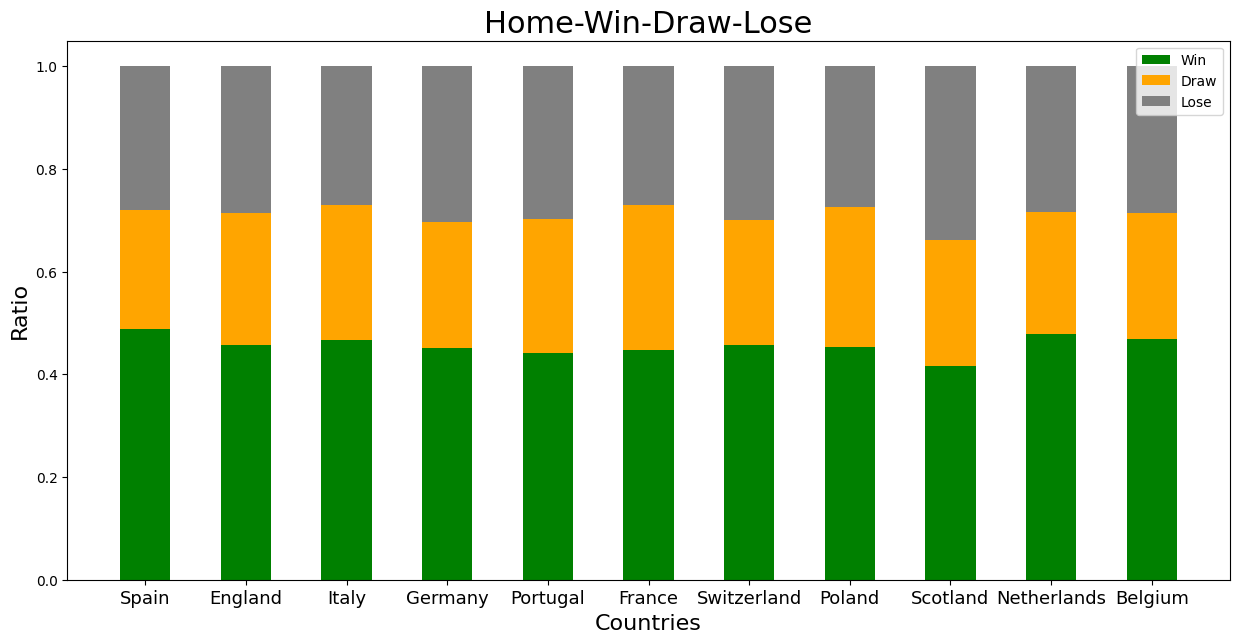

In [30]:
plt.figure(figsize = (15,7))

x = np.arange(len(list_win))

plt.bar(x,list_win,color='green', width = 0.5,label = 'Win')
plt.bar(x,list_draw,color= 'orange',bottom = list_win,width = 0.5,label = 'Draw')
plt.bar(x,list_lose,color= 'grey',bottom =[x+y for x,y in zip(list_win,list_draw)],width = 0.5,label = 'Lose')

#label

plt.xticks(x,list_countries, fontsize = 13)
plt.title('Home-Win-Draw-Lose',fontsize = 22)
plt.xlabel('Countries', fontsize = 16)
plt.ylabel('Ratio', fontsize = 16)


plt.legend(loc = 'upper right')

plt.savefig('Win_Draw_Lose.png')
plt.show()

In [31]:
for i in matches:
    i['winner'] = np.where(i['win']==1, i['home_team'],i['away_team'])

In [32]:
top_teams_Spain = pd.crosstab(index = matches_Spain['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Eng = pd.crosstab(index = matches_Eng['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Ger = pd.crosstab(index = matches_Ger['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_France = pd.crosstab(index = matches_France['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Italy = pd.crosstab(index = matches_Italy['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Pol = pd.crosstab(index = matches_Pol['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Swt = pd.crosstab(index = matches_Swt['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Ned = pd.crosstab(index = matches_Ned['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Scot = pd.crosstab(index = matches_Scot['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Por = pd.crosstab(index = matches_Por['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Bel = pd.crosstab(index = matches_Bel['winner'], columns = 'count').nlargest(10,'count')['count']

top_teams = [top_teams_Spain,top_teams_Eng,top_teams_Ger,top_teams_France,top_teams_Italy,top_teams_Pol,top_teams_Swt,
            top_teams_Ned,top_teams_Scot,top_teams_Por,top_teams_Bel]

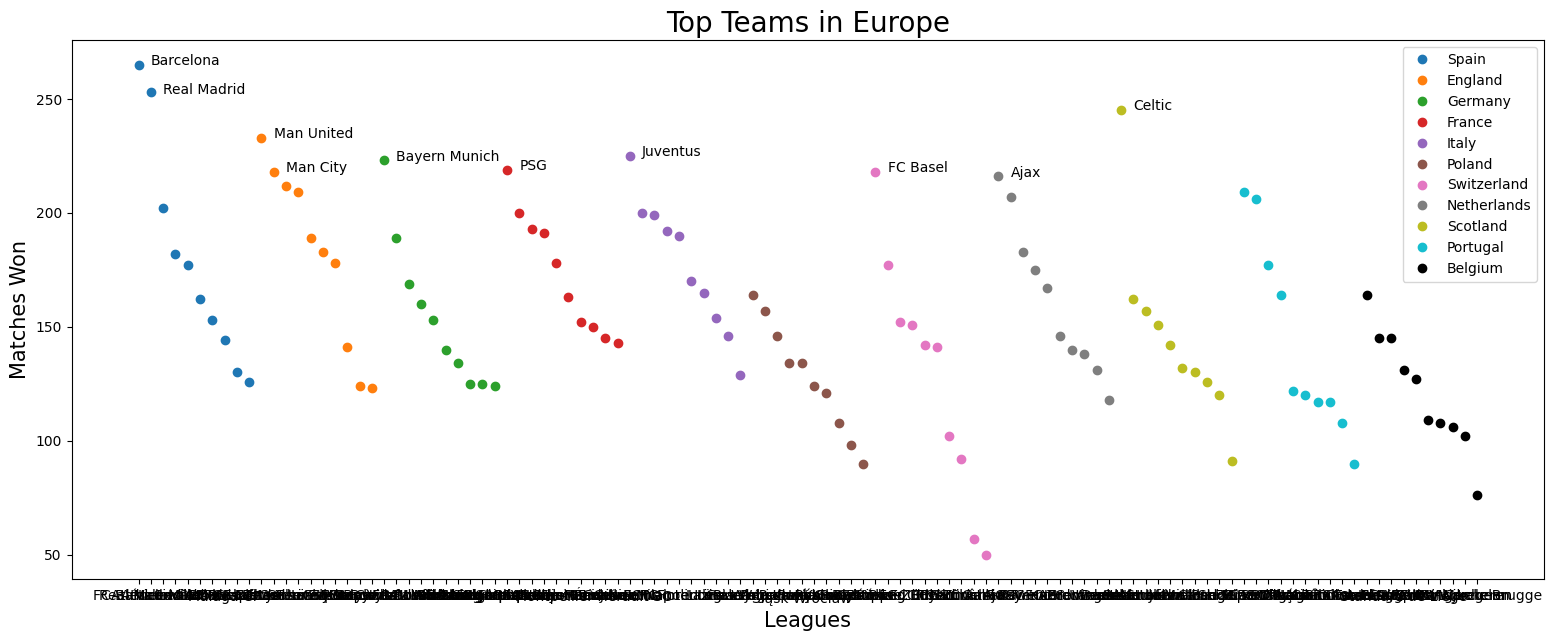

In [33]:
plt.figure(figsize=(19,7))
#defining all the plots with respect to all the leagues
ax1 = plt.plot(top_teams_Spain,'o',label = 'Spain');
ax2 = plt.plot(top_teams_Eng,'o',label = 'England');
ax3 = plt.plot(top_teams_Ger,'o',label = 'Germany');
ax4 = plt.plot(top_teams_France,'o',label = 'France');
ax5 = plt.plot(top_teams_Italy,'o',label = 'Italy');
ax6 = plt.plot(top_teams_Pol,'o',label = 'Poland');
ax7 = plt.plot(top_teams_Swt,'o',label = 'Switzerland');
ax8 = plt.plot(top_teams_Ned,'o',label = 'Netherlands');
ax9 = plt.plot(top_teams_Scot,'o',label = 'Scotland');
ax10 = plt.plot(top_teams_Por,'o',label = 'Portugal');
ax11 = plt.plot(top_teams_Bel,'ko',label = 'Belgium');
plt.legend(loc = 'best');
plt.title('Top Teams in Europe', fontsize= 20)
plt.xlabel('Leagues',fontsize = 15)
plt.ylabel('Matches Won',fontsize = 15)

#Annotations for to Top Ten Teams
plt.annotate('Barcelona',(1,265))
plt.annotate('Real Madrid',(2,252))
plt.annotate('Celtic',(81,245))
plt.annotate('Man United',(11,233))
plt.annotate('Juventus',(41,225))
plt.annotate('Bayern Munich',(21,223))
plt.annotate('PSG',(31,219))
plt.annotate('Man City',(12,218))
plt.annotate('FC Basel',(61,218))
plt.annotate('Ajax',(71,216))



plt.savefig('Top Teams in Europe.png')
    

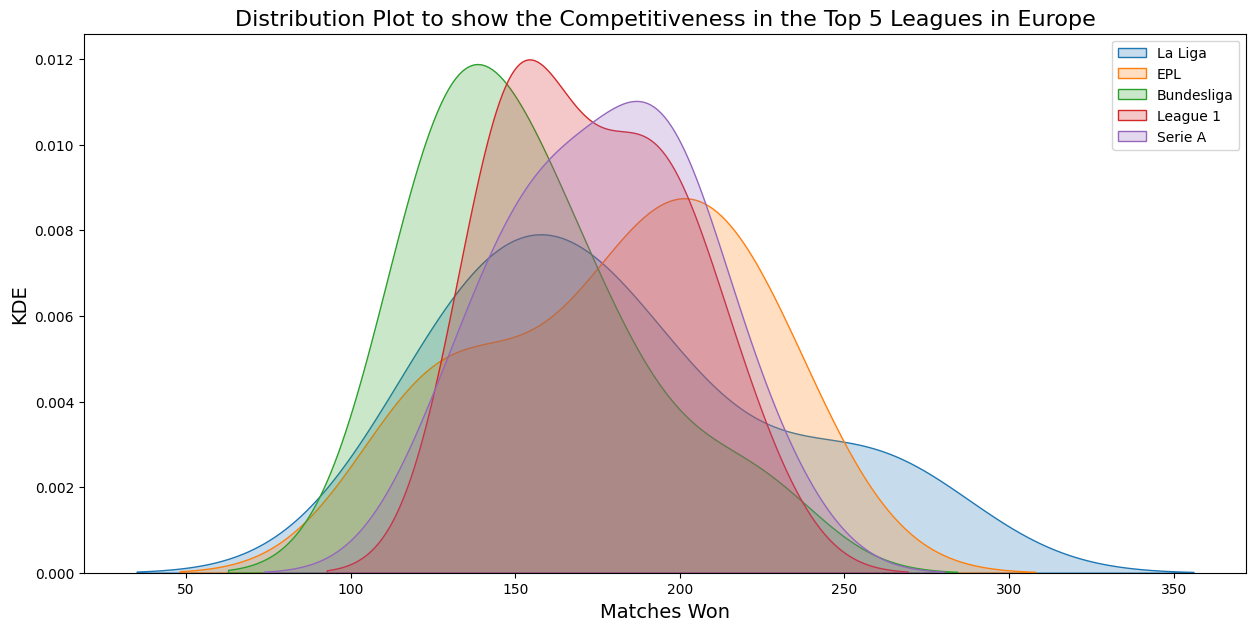

In [34]:

plt.figure(figsize=(15, 7))
ax1 = sns.kdeplot(top_teams_Spain, label='La Liga', fill=True)
ax2 = sns.kdeplot(top_teams_Eng, label='EPL', fill=True)
ax3 = sns.kdeplot(top_teams_Ger, label='Bundesliga', fill=True)
ax4 = sns.kdeplot(top_teams_France, label='League 1', fill=True)
ax5 = sns.kdeplot(top_teams_Italy, label='Serie A', fill=True)

plt.title('Distribution Plot to show the Competitiveness in the Top 5 Leagues in Europe', fontsize=16)
plt.xlabel('Matches Won', fontsize=14)
plt.ylabel('KDE', fontsize=14)
plt.legend()

plt.savefig('Competitiveness in the Top 5 Leagues in Europe.png')
plt.show()
